In [1]:
from Automata import Automata
from utils import *

# Space Specification:

In [2]:
#space=(x1_max, x2_max, x3_range, NX1, NX2, NX3)
space=(10, 10, (-np.pi,np.pi), 40, 40, 30)
#controls = (u1_min, u1_max, u2_min, u2_max, NU1, NU2)
controls = (0.25, 1, -1, 1, 3, 5)
#inputs=(w1,w2,w3,t)
inputs=((0.05,0.05,0.05),1)

# x0_min = 0,0,x3_range[0]
# x0_max = x1_m,x2_m,x3_range[1]
x0_min=(0,0,space[2][0])
x0_max=(space[0],space[1],space[2][1])

In [3]:
def TransFunct(x,u, w, tau):
  z_next = x[2] + tau * (u[1] + w[2])
  z_wrapped = ((z_next + np.pi) % (2*np.pi)) - np.pi
  return ((x[0]+tau*(u[0]*math.cos(x[2])+w[0])),(x[1]+tau*(u[0]*math.sin(x[2])+w[1])), z_wrapped)

def Dx(u, tau):
  return np.array([[1, 0, tau*abs(u[0])],[0, 1, tau*abs(u[0])],[0, 0, 1]], dtype=float)
def Sx(x_min, x_max):
  return np.array([(x_max[i] - x_min[i]) / 2 for i in range(3)], dtype=float)
def Xx(x_min, x_max):
  return np.array([(x_max[i] + x_min[i]) / 2 for i in range(3)], dtype=float)

def Dw(tau): 
  return np.array([[tau, 0, 0],[0, tau, 0],[0, 0, tau]], dtype=float)
def Sw(w):
  return np.array([w[i] for i in range(3)], dtype=float)
def Wx():
  return [0,0,0]

C:\Users\Gyro\AppData\Local\Temp\ipykernel_3476\2064510973.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', np.max(list(LabelMap.values())) + 1)


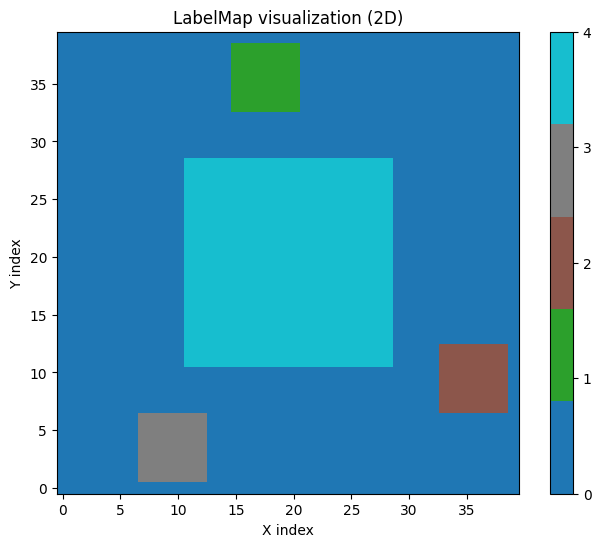

In [4]:
SpecMap = {
    'a' : {0: 'a', 1: 'b', 2: 'c', 3: 'e', 4: 'e'}, # nothing
    'b' : {0: 'b', 1: 'b', 2: 'e', 3: 'd', 4: 'e'}, # reched R1
    'c' : {0: 'c', 1: 'e', 2: 'c', 3: 'd', 4: 'e'}, # reached R2
    'd' : {0: 'd', 1: 'd', 2: 'd', 3: 'd', 4: 'd'}, # accomplished
    'e' : {0: 'e', 1: 'e', 2: 'e', 3: 'e', 4: 'e'}  # trash
}

accepting_states = ['d']
trash_states = ['e']

Rs = {
  4: (((3.0, 3.0, -np.pi), (7.0, 7.0, np.pi)), True),
  3: (((2.0, 0.5, -np.pi), (3.0, 1.5, np.pi)), True),
  2: (((8.5, 2.0, -np.pi), (9.5, 3.0, np.pi)), True),
  1: (((4.0, 8.5, -np.pi), (5.0, 9.5, np.pi)), True),
}

LabelMap , default_states= build_LabelMap(space, x0_min, x0_max, Rs)

import matplotlib.pyplot as plt
import numpy as np

def plot_LabelMap_2D(LabelMap, space):
    """
    Plots a 2D grid showing the label of each cell based on the first two coordinates.
    Ignores the third dimension (z-axis).
    """
    NX1, NX2 = space[3], space[4]
    
    grid = np.zeros((NX1, NX2))  # Initialize a grid
    
    for (i, j), label in LabelMap.items():
        grid[i, j] = label  # Only consider first two coordinates
    
    plt.figure(figsize=(8, 6))
    cmap = plt.cm.get_cmap('tab10', np.max(list(LabelMap.values())) + 1)
    im = plt.imshow(grid.T, origin='lower', cmap=cmap, interpolation='nearest')
    plt.colorbar(im, ticks=np.arange(np.max(list(LabelMap.values()))+1))
    plt.xlabel('X index')
    plt.ylabel('Y index')
    plt.title('LabelMap visualization (2D)')
    plt.show()

# Call the function
plot_LabelMap_2D(LabelMap, space)

# Generation

In [5]:
skip = True
SymbolicController = Automata()

import pickle
try:
    with open("controller_h.pkl", "rb") as f:
        h = pickle.load(f)
    with open("V.pkl", "rb") as f:
        V = pickle.load(f)
except FileNotFoundError:
    print("Warning: controller_h.pkl not found, using SymbolicController.h")
    skip = False

In [6]:
if not skip:
    # step 1: generate the TransitionMap and define the automata
    SymbolicController.set_TransMap(TransMap(x0_min, x0_max, controls, inputs, space, TransFunct, Dx, Dw, Sx, Sw, Xx, Wx))

In [7]:
if not skip:
    R = SymbolicController.ApplySecurity(set([(i,j,k) for i in range(space[3]) for j in range(space[4]) for k in range(space[5])]))

In [8]:
if not skip:
    print(len(R))

In [9]:
def plot_R_3d(R):
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D

    xs = [i for (i,j,k) in R]
    ys = [j for (i,j,k) in R]
    zs = [k for (i,j,k) in R]

    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(xs, ys, zs, s=5, c='green')

    ax.set_xlabel("i")
    ax.set_ylabel("j")
    ax.set_zlabel("k")

    plt.show()


In [10]:
if not skip:
    plot_R_3d(R)

In [11]:
if not skip:
    # 2. Build product automaton
    SymbolicController.ToProdAutomate(SpecMap, LabelMap, 'a')

In [12]:
if not skip:
    # 3. Define target product states
    target = [(x,q) for (x,q) in SymbolicController.TransMap.keys() if q in accepting_states]

In [13]:
if not skip:
    V = SymbolicController.ApplyReachability(target)
    h = SymbolicController.h

In [14]:
if not skip:
    # 4. Save controller h
    import pickle
    with open("controller_h.pkl", "wb") as f:
        pickle.dump(SymbolicController.h, f)
    with open("V.pkl", "wb") as f:
        pickle.dump(V, f)
    print("Controller saved to controller_h.pkl")

# Visualisation

In [15]:
# Helper functions for concrete simulation

def generate_disturbance(w):
    """Generate random disturbance w within bounds"""
    w1 = np.random.uniform(-w[0], w[0])
    w2 = np.random.uniform(-w[1], w[1])
    w3 = np.random.uniform(-w[2], w[2])
    return (w1, w2, w3)

def discrete_to_concrete_control(discrete_control_idx, controls):
    """Convert discrete control index to concrete control value"""
    CntD = ControlD(controls)
    idx = int(discrete_control_idx)
    if idx < 0 or idx >= len(CntD):
        raise ValueError(f"Control index {idx} out of bounds (0-{len(CntD)-1})")
    return CntD[idx]


def get_discrete_control_index(u, controls):
    """Find the index of control u in the discrete control set"""
    CntD = ControlD(controls)
    for idx, control in enumerate(CntD):
        if np.allclose(control, u, atol=1e-9):
            return idx
    return None

In [16]:
reachable_starts = [state for state in V if state[1] == 'a']  # Only states with spec 'a'
print(reachable_starts)

[((39, 0, 24), 'a'), ((4, 18, 19), 'a'), ((34, 18, 0), 'a'), ((6, 7, 0), 'a'), ((7, 37, 0), 'a'), ((25, 26, 20), 'a'), ((14, 3, 15), 'a'), ((33, 16, 26), 'a'), ((2, 29, 15), 'a'), ((35, 11, 16), 'a'), ((10, 30, 18), 'a'), ((26, 34, 16), 'a'), ((35, 0, 19), 'a'), ((35, 37, 2), 'a'), ((13, 10, 0), 'a'), ((23, 37, 16), 'a'), ((9, 18, 6), 'a'), ((31, 11, 16), 'a'), ((36, 24, 14), 'a'), ((12, 20, 3), 'a'), ((17, 39, 8), 'a'), ((6, 24, 11), 'a'), ((34, 6, 14), 'a'), ((5, 34, 20), 'a'), ((31, 6, 12), 'a'), ((6, 25, 14), 'a'), ((4, 19, 17), 'a'), ((13, 29, 28), 'a'), ((9, 7, 26), 'a'), ((1, 27, 23), 'a'), ((31, 3, 27), 'a'), ((37, 18, 8), 'a'), ((37, 36, 2), 'a'), ((0, 7, 16), 'a'), ((4, 11, 28), 'a'), ((2, 30, 13), 'a'), ((22, 3, 17), 'a'), ((36, 19, 1), 'a'), ((3, 17, 25), 'a'), ((17, 33, 9), 'a'), ((14, 33, 7), 'a'), ((9, 19, 4), 'a'), ((3, 12, 21), 'a'), ((3, 1, 24), 'a'), ((2, 33, 21), 'a'), ((3, 38, 7), 'a'), ((35, 14, 5), 'a'), ((24, 12, 8), 'a'), ((38, 9, 3), 'a'), ((32, 13, 11), 'a'),

((19, 6, 7), 'a')
(4.75, 1.5, -1.6755160819145565)
Reached accepting state 'd', stopping simulation.


C:\Users\Gyro\AppData\Local\Temp\ipykernel_3476\1693733052.py:63: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', np.max(list(LabelMap.values())) + 1)


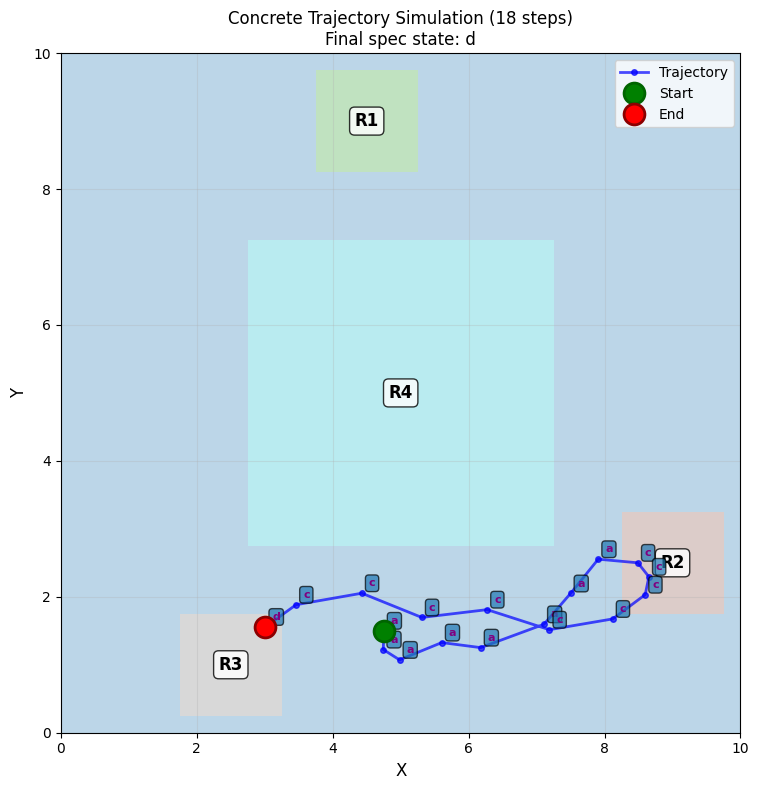


Trajectory summary:
  Total steps: 18
  Final position: (3.01, 1.56, -3.00)
  Final spec state: d


In [17]:
import random
from utils import *

fixed_start = random.choice([state for state in V if state[1] == 'a'])
print(fixed_start)

fixed_start_cell = fixed_start[0]
fixed_start_spec = fixed_start[1]

x = cell_center(fixed_start_cell, space)
print(x)

# determine u:
u = h[fixed_start]
spec_state = fixed_start_spec

import matplotlib.pyplot as plt
import numpy as np

# Storage for trajectory
trajectory = [x]
spec_states = [spec_state]

for i in range(50):
    w = generate_disturbance(inputs[0])
    x = TransFunct(x, u, w, tau=inputs[1])
    
    trajectory.append(x)
    
    state = SpaceD(x,x,space,True)[0] if SpaceD(x,x,space,True) else None

    # Check if x or y went out of bounds
    if not (0 <= x[0] <= space[0] and 0 <= x[1] <= space[1]):
        print(f"OUT OF BOUNDS at step {i+1}! x={x[0]:.3f}, y={x[1]:.3f}")
        break
    
    spec_state = SpecMap[spec_state][LabelMap[state[0], state[1]]]
    spec_states.append(spec_state)
    
    if spec_state == 'e':
        print("Entered trash state 'e', stopping simulation.")
        break
    elif spec_state == 'd':
        print("Reached accepting state 'd', stopping simulation.")
        break
    
    u = h[(state, spec_state)]

# Convert trajectory to numpy array for plotting
trajectory = np.array(trajectory)

# Create visualization
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the grid cells colored by their labels
NX1, NX2 = space[3], space[4]
grid = np.zeros((NX1, NX2))

for (i, j), label in LabelMap.items():
    grid[i, j] = label

# Plot the grid with colormap
cmap = plt.cm.get_cmap('tab10', np.max(list(LabelMap.values())) + 1)
im = plt.imshow(grid.T, origin='lower', cmap=cmap, interpolation='nearest', 
                extent=[0, space[0], 0, space[1]], alpha=0.3)

# Draw region boundaries R1–R4
for label, ((rmin, rmax), intersect) in Rs.items():
    xmin, ymin = rmin[0], rmin[1]
    xmax, ymax = rmax[0], rmax[1]
    width, height = xmax - xmin, ymax - ymin
    rect = plt.Rectangle((xmin, ymin), width, height,
                         alpha=0, edgecolor='black', linewidth=2)
    ax.add_patch(rect)
    ax.text((xmin+xmax)/2, (ymin+ymax)/2, f"R{label}",
            ha='center', va='center', fontsize=12, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Plot trajectory
ax.plot(trajectory[:, 0], trajectory[:, 1], '-o', alpha=0.7, linewidth=2, 
        markersize=4, color='blue', label='Trajectory')

# Mark start point
ax.plot(trajectory[0, 0], trajectory[0, 1], 'go', markersize=15, 
        markeredgecolor='darkgreen', markeredgewidth=2, label='Start', zorder=10)

# Mark end point
ax.plot(trajectory[-1, 0], trajectory[-1, 1], 'ro', markersize=15,
        markeredgecolor='darkred', markeredgewidth=2, label='End', zorder=10)

# Add spec state annotations at key points
step_interval = max(1, len(trajectory) // 10)  # Show ~10 annotations
for i in range(0, len(trajectory), step_interval):
    if i < len(spec_states):
        ax.annotate(f"{spec_states[i]}", 
                   xy=(trajectory[i, 0], trajectory[i, 1]),
                   xytext=(5, 5), textcoords='offset points',
                   fontsize=8, color='purple', fontweight='bold',
                   bbox=dict(boxstyle='round,pad=0.3', alpha=0.7))

ax.set_xlim(0, space[0])
ax.set_ylim(0, space[1])
ax.set_xlabel('X', fontsize=12)
ax.set_ylabel('Y', fontsize=12)
ax.grid(True, alpha=0.3)
ax.legend(loc='upper right')
ax.set_title(f'Concrete Trajectory Simulation ({len(trajectory)} steps)\nFinal spec state: {spec_states[-1]}', 
             fontsize=12)

plt.tight_layout()
plt.show()

print(f"\nTrajectory summary:")
print(f"  Total steps: {len(trajectory)}")
print(f"  Final position: ({trajectory[-1, 0]:.2f}, {trajectory[-1, 1]:.2f}, {trajectory[-1, 2]:.2f})")
print(f"  Final spec state: {spec_states[-1]}")

C:\Users\Gyro\AppData\Local\Temp\ipykernel_3476\839102708.py:63: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', np.max(list(LabelMap.values())) + 1)
C:\Users\Gyro\AppData\Local\Temp\ipykernel_3476\839102708.py:106: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right')


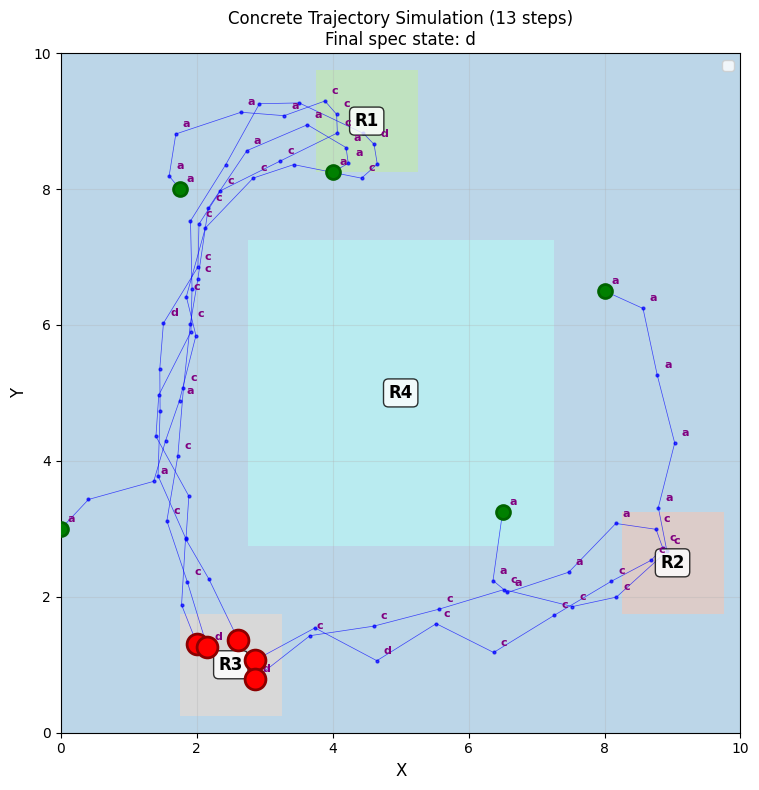


Trajectory summary:
  Total steps: 13
  Final position: (2.86, 0.80, -3.01)
  Final spec state: d


In [18]:
import random
from utils import *
import matplotlib.pyplot as plt
import numpy as np

N = 5
trajectories = []

for i in range(N):

    fixed_start = random.choice([state for state in V if state[1] == 'a'])

    fixed_start_cell = fixed_start[0]
    fixed_start_spec = fixed_start[1]

    x = cell_center(fixed_start_cell, space)

    # determine u:
    u = h[fixed_start]
    spec_state = fixed_start_spec

    trajectory = [x]
    spec_states = [spec_state]

    for i in range(50):
        w = generate_disturbance(inputs[0])
        x = TransFunct(x, u, w, tau=inputs[1])
        
        trajectory.append(x)
        
        state = SpaceD(x,x,space,True)[0] if SpaceD(x,x,space,True) else None

        # Check if x or y went out of bounds
        if not (0 <= x[0] <= space[0] and 0 <= x[1] <= space[1]):
            print(f"OUT OF BOUNDS at step {i+1}! x={x[0]:.3f}, y={x[1]:.3f}")
            break
        
        spec_state = SpecMap[spec_state][LabelMap[state[0], state[1]]]
        spec_states.append(spec_state)
        
        if spec_state == 'e':
            break
        elif spec_state == 'd':
            break
        
        u = h[(state, spec_state)]

    # Convert trajectory to numpy array for plotting
    trajectory = np.array(trajectory)
    trajectories.append(trajectory)

# Create visualization
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the grid cells colored by their labels
NX1, NX2 = space[3], space[4]
grid = np.zeros((NX1, NX2))

for (i, j), label in LabelMap.items():
    grid[i, j] = label

# Plot the grid with colormap
cmap = plt.cm.get_cmap('tab10', np.max(list(LabelMap.values())) + 1)
im = plt.imshow(grid.T, origin='lower', cmap=cmap, interpolation='nearest', 
                extent=[0, space[0], 0, space[1]], alpha=0.3)

# Draw region boundaries R1–R4
for label, ((rmin, rmax), intersect) in Rs.items():
    xmin, ymin = rmin[0], rmin[1]
    xmax, ymax = rmax[0], rmax[1]
    width, height = xmax - xmin, ymax - ymin
    rect = plt.Rectangle((xmin, ymin), width, height,
                         alpha=0, edgecolor='black', linewidth=2)
    ax.add_patch(rect)
    ax.text((xmin+xmax)/2, (ymin+ymax)/2, f"R{label}",
            ha='center', va='center', fontsize=12, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Plot trajectories
for trajectory in trajectories:
    ax.plot(trajectory[:, 0], trajectory[:, 1], '-o', alpha=0.7, linewidth=0.5, 
            markersize=2, color='blue')

    # Mark start point
    ax.plot(trajectory[0, 0], trajectory[0, 1], 'go', markersize=10, 
            markeredgecolor='darkgreen', markeredgewidth=2, zorder=10)

    # Mark end point
    ax.plot(trajectory[-1, 0], trajectory[-1, 1], 'ro', markersize=15,
            markeredgecolor='darkred', markeredgewidth=2, zorder=10)

    # Add spec state annotations at key points
    step_interval = max(1, len(trajectory) // 10)  # Show ~10 annotations
    for i in range(0, len(trajectory), step_interval):
        if i < len(spec_states):
            ax.annotate(f"{spec_states[i]}", 
                    xy=(trajectory[i, 0], trajectory[i, 1]),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=8, color='purple', fontweight='bold')

ax.set_xlim(0, space[0])
ax.set_ylim(0, space[1])
ax.set_xlabel('X', fontsize=12)
ax.set_ylabel('Y', fontsize=12)
ax.grid(True, alpha=0.3)
ax.legend(loc='upper right')
ax.set_title(f'Concrete Trajectory Simulation ({len(trajectory)} steps)\nFinal spec state: {spec_states[-1]}', 
             fontsize=12)

plt.tight_layout()
plt.show()

print(f"\nTrajectory summary:")
print(f"  Total steps: {len(trajectory)}")
print(f"  Final position: ({trajectory[-1, 0]:.2f}, {trajectory[-1, 1]:.2f}, {trajectory[-1, 2]:.2f})")
print(f"  Final spec state: {spec_states[-1]}")

C:\Users\Gyro\AppData\Local\Temp\ipykernel_3476\1216318720.py:65: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', np.max(list(LabelMap.values())) + 1)
C:\Users\Gyro\AppData\Local\Temp\ipykernel_3476\1216318720.py:108: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right')


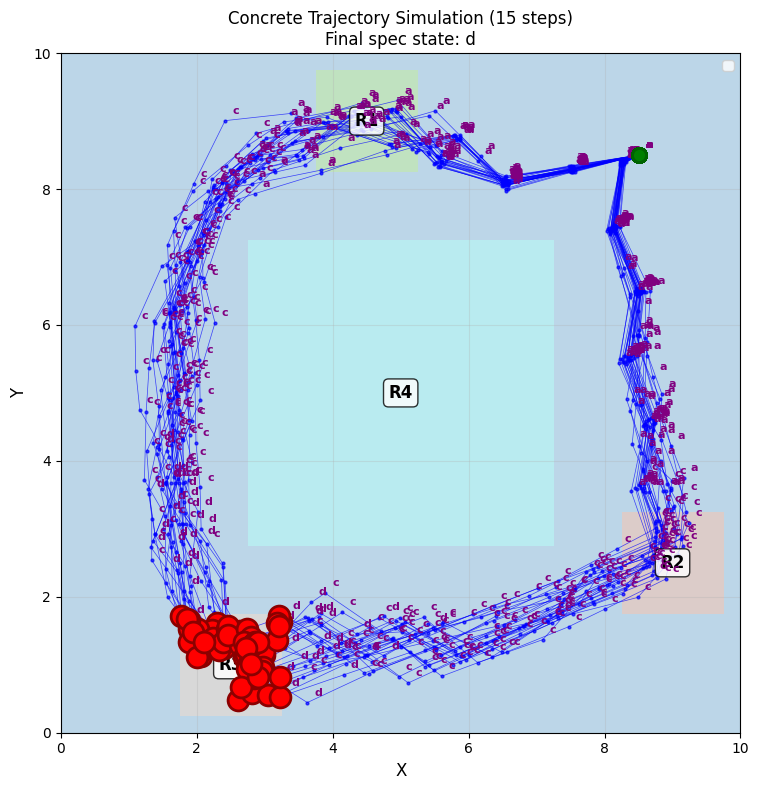


Trajectory summary:
  Total steps: 15
  Final position: (3.22, 0.82, -2.79)
  Final spec state: d


In [19]:
import random
from utils import *
import matplotlib.pyplot as plt
import numpy as np

N = 30
trajectories = []

starts = []
starts.append(random.choice([state for state in V if state[1] == 'a' and state[0][0] == 34 and state[0][1] == 34 and state[0][2]==1]))
starts.append(random.choice([state for state in V if state[1] == 'a' and state[0][0] == 34 and state[0][1] == 34 and state[0][2]==2]))

for fixed_start in starts:
    for i in range(N):    
        fixed_start_cell = fixed_start[0]
        fixed_start_spec = fixed_start[1]

        x = cell_center(fixed_start_cell, space)
    
        # determine u:
        u = h[fixed_start]
        spec_state = fixed_start_spec

        trajectory = [x]
        spec_states = [spec_state]

        for i in range(50):
            w = generate_disturbance(inputs[0])
            x = TransFunct(x, u, w, tau=inputs[1])
            
            trajectory.append(x)
            
            state = SpaceD(x,x,space,True)[0] if SpaceD(x,x,space,True) else None

            # Check if x or y went out of bounds
            if not (0 <= x[0] <= space[0] and 0 <= x[1] <= space[1]):
                print(f"OUT OF BOUNDS at step {i+1}! x={x[0]:.3f}, y={x[1]:.3f}")
                break
            
            spec_state = SpecMap[spec_state][LabelMap[state[0], state[1]]]
            spec_states.append(spec_state)
            
            if spec_state == 'e':
                break
            elif spec_state == 'd':
                break
            
            u = h[(state, spec_state)]

        # Convert trajectory to numpy array for plotting
        trajectory = np.array(trajectory)
        trajectories.append(trajectory)

# Create visualization
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the grid cells colored by their labels
NX1, NX2 = space[3], space[4]
grid = np.zeros((NX1, NX2))

for (i, j), label in LabelMap.items():
    grid[i, j] = label

# Plot the grid with colormap
cmap = plt.cm.get_cmap('tab10', np.max(list(LabelMap.values())) + 1)
im = plt.imshow(grid.T, origin='lower', cmap=cmap, interpolation='nearest', 
                extent=[0, space[0], 0, space[1]], alpha=0.3)

# Draw region boundaries R1–R4
for label, ((rmin, rmax), intersect) in Rs.items():
    xmin, ymin = rmin[0], rmin[1]
    xmax, ymax = rmax[0], rmax[1]
    width, height = xmax - xmin, ymax - ymin
    rect = plt.Rectangle((xmin, ymin), width, height,
                         alpha=0, edgecolor='black', linewidth=2)
    ax.add_patch(rect)
    ax.text((xmin+xmax)/2, (ymin+ymax)/2, f"R{label}",
            ha='center', va='center', fontsize=12, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Plot trajectories
for trajectory in trajectories:
    ax.plot(trajectory[:, 0], trajectory[:, 1], '-o', alpha=0.7, linewidth=0.5, 
            markersize=2, color='blue')

    # Mark start point
    ax.plot(trajectory[0, 0], trajectory[0, 1], 'go', markersize=10, 
            markeredgecolor='darkgreen', markeredgewidth=2, zorder=10)

    # Mark end point
    ax.plot(trajectory[-1, 0], trajectory[-1, 1], 'ro', markersize=15,
            markeredgecolor='darkred', markeredgewidth=2, zorder=10)

    # Add spec state annotations at key points
    step_interval = max(1, len(trajectory) // 10)  # Show ~10 annotations
    for i in range(0, len(trajectory), step_interval):
        if i < len(spec_states):
            ax.annotate(f"{spec_states[i]}", 
                    xy=(trajectory[i, 0], trajectory[i, 1]),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=8, color='purple', fontweight='bold')

ax.set_xlim(0, space[0])
ax.set_ylim(0, space[1])
ax.set_xlabel('X', fontsize=12)
ax.set_ylabel('Y', fontsize=12)
ax.grid(True, alpha=0.3)
ax.legend(loc='upper right')
ax.set_title(f'Concrete Trajectory Simulation ({len(trajectory)} steps)\nFinal spec state: {spec_states[-1]}', 
             fontsize=12)

plt.tight_layout()
plt.show()

print(f"\nTrajectory summary:")
print(f"  Total steps: {len(trajectory)}")
print(f"  Final position: ({trajectory[-1, 0]:.2f}, {trajectory[-1, 1]:.2f}, {trajectory[-1, 2]:.2f})")
print(f"  Final spec state: {spec_states[-1]}")

In [52]:
import pybullet as p
import pybullet_data
import numpy as np
import time
import random
from utils import *

# Disconnect any existing PyBullet connection
try:
    p.disconnect()
except:
    pass

# Generate a trajectory first
fixed_start = random.choice([state for state in V if state[1] == 'a'])
fixed_start_cell = fixed_start[0]
fixed_start_spec = fixed_start[1]

x = cell_center(fixed_start_cell, space)
u = h[fixed_start]
spec_state = fixed_start_spec

trajectory = [x]
spec_states = [spec_state]

for i in range(50):
    w = generate_disturbance(inputs[0])
    x = TransFunct(x, u, w, tau=inputs[1])
    
    trajectory.append(x)
    
    state = SpaceD(x,x,space,True)[0] if SpaceD(x,x,space,True) else None

    if not (0 <= x[0] <= space[0] and 0 <= x[1] <= space[1]):
        print(f"OUT OF BOUNDS at step {i+1}!")
        break
    
    spec_state = SpecMap[spec_state][LabelMap[state[0], state[1]]]
    spec_states.append(spec_state)
    
    if spec_state == 'e':
        print("Entered trash state 'e', stopping simulation.")
        break
    elif spec_state == 'd':
        print("Reached accepting state 'd', stopping simulation.")
        break
    
    u = h[(state, spec_state)]

trajectory = np.array(trajectory)
print(f"Generated trajectory with {len(trajectory)} steps")
print(f"Start: ({trajectory[0, 0]:.2f}, {trajectory[0, 1]:.2f})")
print(f"End: ({trajectory[-1, 0]:.2f}, {trajectory[-1, 1]:.2f})")
print(f"Final spec state: {spec_states[-1]}")

# Initialize PyBullet
physicsClient = p.connect(p.GUI)
p.setAdditionalSearchPath(pybullet_data.getDataPath())
p.setGravity(0, 0, -9.8)

# Load ground plane
planeId = p.loadURDF("plane.urdf")

Reached accepting state 'd', stopping simulation.
Generated trajectory with 15 steps
Start: (9.00, 4.75)
End: (3.15, 1.40)
Final spec state: d


In [53]:
# Create visual markers for regions R1-R4
region_colors = {
    1: [0, 1, 0, 0.4],  # Green - R1
    2: [1, 0, 0, 0.4],  # Red - R2
    3: [0, 0, 1, 0.4],  # Blue - R3
    4: [1, 1, 0, 0.4],  # Yellow - R4 (obstacle)
}

for label, ((rmin, rmax), _) in Rs.items():
    pos = [(rmin[0]+rmax[0])/2, (rmin[1]+rmax[1])/2, 0.5]  # Height at 0.5
    size = [(rmax[0]-rmin[0])/2, (rmax[1]-rmin[1])/2, 0.5]
    color = region_colors.get(label, [0.5, 0.5, 0.5, 0.4])
    
    vis_id = p.createVisualShape(p.GEOM_BOX, halfExtents=size, rgbaColor=color)
    p.createMultiBody(baseMass=0, baseVisualShapeIndex=vis_id, basePosition=pos)
    
    print(f"Created region R{label} at ({pos[0]:.1f}, {pos[1]:.1f})")

Created region R4 at (5.0, 5.0)
Created region R3 at (2.5, 1.0)
Created region R2 at (9.0, 2.5)
Created region R1 at (4.5, 9.0)


In [54]:
# Create collision box for obstacle (R4)
rmin, rmax = (3.0, 3.0), (7.0, 7.0)

obs_center = [(rmin[0] + rmax[0]) / 2,
              (rmin[1] + rmax[1]) / 2,
              0.5]
obs_half_extents = [(rmax[0] - rmin[0]) / 2,
                    (rmax[1] - rmin[1]) / 2,
                    0.5]

# Create collision shape for R4 obstacle
obs_shape = p.createCollisionShape(p.GEOM_BOX, halfExtents=obs_half_extents)
p.createMultiBody(baseMass=0, baseCollisionShapeIndex=obs_shape, basePosition=obs_center)

print(f"Created obstacle at ({obs_center[0]:.1f}, {obs_center[1]:.1f})")

Created obstacle at (5.0, 5.0)


In [55]:
# Load robot at starting position
robotStartPos = [trajectory[0][0], trajectory[0][1], 0.1]
robotStartOrientation = p.getQuaternionFromEuler([0, 0, trajectory[0][2]])

robot = p.loadURDF("r2d2.urdf", basePosition=robotStartPos, baseOrientation=robotStartOrientation)

# Set camera to view from directly above (top-down 2D view)
p.resetDebugVisualizerCamera(
    cameraDistance=12,
    cameraYaw=0,
    cameraPitch=-89,  # Almost directly above (-90 would be perfectly top-down)
    cameraTargetPosition=[space[0]/2, space[1]/2, 0]
)

print(f"Robot loaded at ({robotStartPos[0]:.2f}, {robotStartPos[1]:.2f})")

Robot loaded at (9.00, 4.75)


In [57]:
# Animate the robot following the trajectory
print(f"\nAnimating trajectory ({len(trajectory)} steps)...")
print(f"Spec states: {' -> '.join(spec_states[:10])}..." if len(spec_states) > 10 else f"Spec states: {' -> '.join(spec_states)}")

for i, x in enumerate(trajectory):
    pos = [x[0], x[1], 0.1]
    orn = p.getQuaternionFromEuler([0, 0, x[2]])
    p.resetBasePositionAndOrientation(robot, pos, orn)
    
    # Add debug text showing current state
    if i < len(spec_states):
        p.addUserDebugText(
            text=f"Step {i}: State '{spec_states[i]}'",
            textPosition=[pos[0], pos[1], 0.5],
            textColorRGB=[1, 1, 1],
            textSize=1.2,
            lifeTime=0.1
        )
    
    p.stepSimulation()
    time.sleep(0.5)

print(f"\nAnimation complete!")
print(f"Final position: ({trajectory[-1, 0]:.2f}, {trajectory[-1, 1]:.2f})")
print(f"Final spec state: {spec_states[-1]}")


Animating trajectory (15 steps)...
Spec states: a -> a -> a -> a -> a -> a -> a -> c -> c -> c...

Animation complete!
Final position: (3.15, 1.40)
Final spec state: d

Animation complete!
Final position: (3.15, 1.40)
Final spec state: d
